In [2]:
%matplotlib inline

import numpy as np
# from neuron import h,gui
import matplotlib.pyplot as plt
import glob

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase

import pwlf
import sklearn.cluster as cluster

In [2]:
def estimateNeuronOrientation():
    x1,x2 = h.x3d(0,sec=h.apic[0]),h.x3d(int(h.n3d(sec=h.apic[0])-1),sec=h.apic[0])
    y1,y2 = h.y3d(0,sec=h.apic[0]),h.y3d(int(h.n3d(sec=h.apic[0])-1),sec=h.apic[0])
    theta = np.arctan((x2-x1)/(y2-y1)) + ((x1>x2)+(y1>y2))*np.pi/2
    return theta

def rotate2d(x,y,theta):
    xnew = np.cos(theta)*x - np.sin(theta)*y
    ynew = np.sin(theta)*x + np.cos(theta)*y
    return xnew,ynew

def find_vpeaks(v, curve_tol=-1e-5):
    dv = np.diff(v)
    ddv = np.diff(dv)
    pks = np.where((dv>0)[:-1]*(dv<0)[1:])[0] + 1
    pks = np.array([pk for pk in pks if pk > 100])
    win = 70
#     print([ddv[pk-win:pk+win].mean() for pk in pks])
    pks = np.array([pk for pk in pks if ddv[pk-win:pk+win].mean() < curve_tol])
    return pks

def find_nearest_peak(va_pks,vb,win=150):
    vb_pks = [np.max(vb[pk:pk+win]) for pk in va_pks]
    return np.array(vb_pks)

def average_vdenpeaks(vsom,vden):
    vsom_pks = find_vpeaks(vsom)
    vden_pks = find_nearest_peak(vsom_pks,vden)
    vden_pks_av = np.mean(vden_pks[vsom[vsom_pks]>0])
    return vden_pks_av

def caInfluxPerSpike(num_spikes,ca,t):
    int1 = np.sum(ca[1:]*np.diff(t))
    int2 = np.sum(ca[:-1]*np.diff(t))
    cai_per_spike = np.mean([int1,int2])/num_spikes
    return cai_per_spike

def compute_pBAP_tBAP(vsom, vden):
    t_vsom_peaks = find_vpeaks(vsom)
    print(len(t_vsom_peaks))
    vden_base = np.array([np.min(vden[:, t-500:t], axis=1) for t in t_vsom_peaks])
    vden_peak = np.array([np.max(vden[:, t:t+500], axis=1) for t in t_vsom_peaks])
    bAP_amp = vden_peak - vden_base
    
    X = bAP_amp[3:].T
    cluster_model = cluster.AgglomerativeClustering(n_clusters=2).fit(X)
    
    bAPs_in_cluster_1 = bAP_amp[:, cluster_model.labels_== 1].mean() >= bAP_amp[:, cluster_model.labels_== 0].mean()
    
    p_BAP = cluster_model.labels_.mean() if bAPs_in_cluster_1 else 1.0 - cluster_model.labels_.mean()
    
    X = bAP_amp[:, cluster_model.labels_== 1].mean(axis=1) if bAPs_in_cluster_1 else bAP_amp[:, cluster_model.labels_== 0].mean(axis=1)
    print(np.arange(12).shape, X.shape)
    brkpts = pwlf.PiecewiseLinFit(np.arange(12), X).fit(n_segments=3);
    
    t_BAP = brkpts[2]
    
#     plt.plot(bAP_amp[:, cluster_model.labels_== 0], 'C0', alpha=0.5);
#     plt.plot(bAP_amp[:, cluster_model.labels_== 1], 'C1', alpha=0.5);
#     plt.vlines(brkpts, ymin=0, ymax=110)
#     plt.close()
    
    return p_BAP, t_BAP

def cluster_in_bAP(vsom, vden):
    t_vsom_peaks = find_vpeaks(vsom)
    print(len(t_vsom_peaks))
    vden_base = np.array([np.min(vden[:, t-500:t], axis=1) for t in t_vsom_peaks])
    vden_peak = np.array([np.max(vden[:, t:t+500], axis=1) for t in t_vsom_peaks])
    bAP_amp = vden_peak - vden_base
    
    X = bAP_amp[3:].T
    cluster_model = cluster.AgglomerativeClustering(n_clusters=2).fit(X)
    
    bAPs_in_cluster_1 = bAP_amp[:, cluster_model.labels_== 1].mean() >= bAP_amp[:, cluster_model.labels_== 0].mean()
    result = cluster_model.labels_ if bAPs_in_cluster_1 else np.logical_not(cluster_model.labels_).astype(int)
    return result
    
    
    
handRotatedFile = ['20467','31164','40165','60361','81463','82061','82063']
handRotations = [170,130,180,-12,0,-15,-10]

In [49]:
for filename in glob.glob('./amaral_cells/*.hoc'):   
    if True:# not np.any([(filename in csvfile) for csvfile in glob.glob('./amaral_cells/*_%s.csv'%nmod)]):

        Vrest = -64
        h.dt = 0.05
        h.celsius = 35.0
        freq = 20

        print('opening '+filename)

        h.xopen(filename)
        h.xopen('./fig5_data/fixnseg.hoc')

        '''Passive parameters'''
        Rm = 25370
        Cm = 1.41
        RaAll = 150

        h.tstop = 500

        for sec in h.allsec():
            sec.insert('pas')
            sec.v=Vrest
            sec.e_pas=Vrest
            sec.g_pas = 1./Rm
            sec.Ra = RaAll
            sec.cm = Cm

            if 'axon' in sec.name():
                sec.Ra = RaAll/3.

        sl_dendrites = []
        sr_dendrites = []
        slm_dendrites = []

        color=None

        print('Dividing up dendrites')

        for sec in h.allsec():

            if 'axon' not in sec.name():

                h.define_shape()
                x1,x2 = h.x3d(0),h.x3d(h.n3d()-1)
                y1,y2 = h.y3d(0),h.y3d(h.n3d()-1)

                theta = estimateNeuronOrientation()

                if filename[16:21] in handRotatedFile:
                    theta = [np.radians(angle) for fn,angle in zip(handRotatedFile,handRotations) if filename[16:21] in fn][0]

                x1,y1 = rotate2d(x1,y1,theta)
                x2,y2 = rotate2d(x2,y2,theta)
                w = sec.diam
                if sec in list(h.apical):
                        if abs(y1)<100 and abs(y2)<100:
                            if any(sl_dendrites):
                                if sec.diam > sl_dendrites[0].diam:
                                    sl_dendrites.insert(0,sec)
                            else:
                                sl_dendrites.append(sec)
                        elif abs(y1)<400 and abs(y2)<400:
                            sr_dendrites.append(sec)
                        else:
                            slm_dendrites.append(sec)

        '''Active parameters'''
        AXONM = 5
        gna = 0.022
        KMULT = 0.02
        gc = 1e-05
        gcal = gc
        gcan = gc
        gcat = gc
        ghd = 0.00001

        '''Vary K-channel conductances to obtain different spiking regimes (Hemond et al, 2008)'''
        '''Currently set with bursty parameters'''
        gkdr = 0.005
        gkm = 0.017
        gkd = 0.00
        gKc = 5e-5
        gahp = 0.0001

        h.tstop = 500

        ''' Insert channels and set channel conductances'''
        for sec in h.allsec():
            sec.insert('na3')
            sec.insert('kdr')
            sec.insert('kap')
            sec.insert('pas')

            if 'axon' not in sec.name():
                sec.insert('ds')
                sec.insert('hd')
                sec.insert('cacum')
                sec.insert('cal')
                sec.insert('can')
                sec.insert('cat')
                sec.insert('cagk')
                sec.insert('KahpM95')

                sec.depth_cacum = sec.diam/2.

                if 'soma' in sec.name():
                    sec.insert('kd')
                    sec.insert('km')

            sec.v=Vrest
            sec.e_pas=Vrest
            sec.g_pas = 1./Rm
            sec.Ra = RaAll
            sec.cm = Cm
            sec.ek = -90
            sec.ena = 55
            h.ehd_hd = -30

            if h.ismembrane('cal',sec=sec):
                sec.gcalbar_cal=gc
                sec.gcanbar_can=gc
                sec.gcatbar_cat=gc
                sec.gbar_cagk = gKc
                sec.gbar_KahpM95 = gahp

            if 'axon' in sec.name():
                sec.gbar_na3=gna*AXONM
                sec.gkdrbar_kdr=gkdr
                sec.gkabar_kap = KMULT
                sec.sh_kap = 0
                sec.Ra = RaAll/3.

            if 'soma' in sec.name():
                sec.ghdbar_hd=ghd
                sec.gbar_na3=gna
                sec.gkdrbar_kdr=gkdr
                sec.gkabar_kap = KMULT
                sec.gbar_km = gkm
                sec.gkdbar_kd = gkd

            if ('apic' or 'dend') in sec.name():
                sec.ghdbar_hd = ghd
                sec.gbar_na3 = gna
                sec.gkdrbar_kdr = gkdr
                sec.gkabar_kap = KMULT

        '''Set Excitatory weight to produce spiking on 3rd input without inhibition'''

        print('finding synw')

        '''Spike train '''

        stim = h.NetStim()
        stim.interval = 50
        stim.number = 12
        stim.start = 50

        '''Excitatory synaptic input'''

        esyn = h.fac_exp2syn(sl_dendrites[0](0.5)) # mossy fibre input to stratum lucidum dendrite
        esyn.e=10
        esyn.tau1=0.7
        esyn.tau2=7

        encstim = h.NetCon(stim,esyn)

        searching = True
        ubfound = False
        synw = 0
        inc = 0.1
        first_spike = 12
        W = []
        while searching:
            encstim.weight[0] = synw
            t_vec = h.Vector()
            vs_vec = h.Vector()

            vs_vec.record(h.soma(0.5)._ref_v)
            t_vec.record(h._ref_t)

            h.tstop = stim.start*2 + stim.number*stim.interval
            h.run()

            if np.any(np.array(vs_vec)>0):
                first_spike = int(np.array(t_vec)[np.array(vs_vec)>0][0]/stim.interval)

                if first_spike<4 and not np.any(W):
                    inc = 0.01
                    synw-=inc
                    print(synw,inc)

                elif first_spike == 4:
                    inc = 0.01 -0.02*(ubfound)
                    if synw not in W:
                        W.append(synw)
                    synw+=inc
                    print( synw,inc)

                elif first_spike<4 and np.any(W):
                    ubfound = True
                    synw = W[0]-0.01

                elif first_spike>4 and np.any(W):
                    searching = False
                    synw = np.mean(W)

                else:
                    synw+=inc
            else:
                synw+=inc

            print('w=%.2f'%synw)
        for nmod in ['nad', 'ach']: 
            '''Run main simulation'''

            print('Running main simulation')

            '''Spike train '''

            stim = h.NetStim()
            stim.interval = 50
            stim.number = 12
            stim.start = 50

            '''Excitatory synaptic input'''

            esyn = h.fac_exp2syn(sl_dendrites[0](0.5))
            esyn.e=10
            esyn.tau1=0.7
            esyn.tau2=7

            encstim = h.NetCon(stim,esyn)
            encstim.weight[0]=synw

            bAP_av = []
            CaI = []
            p_BAPs = []
            t_BAPs = []

            for ach_imult in np.arange(6): # For full and decrease feedforward inhibition
                isyns = []
                inclist = []
                for sec in [h.soma]+sl_dendrites+sr_dendrites: # split up feedforward inhibition amongst various comparments

                    isyn = h.afacdep_exp2syn(sec(0.5))
                    isyn.e = -75
                    isyn.tau1 = 4
                    isyn.tau2 = 24

                    if nmod == 'nad':
                        isyn.taud = 1600

                    isyns.append(isyn)

                    incstim = h.NetCon(stim,isyn)
                    incstim.delay=3
                    if 'soma' in sec.name():
                        incstim.weight[0] = encstim.weight[0]*ach_imult/2.0
                    if sec in sl_dendrites+sr_dendrites:
                        incstim.weight[0] = encstim.weight[0]*ach_imult/(2.0*len(sl_dendrites+sr_dendrites))

                    inclist.append(incstim)


                '''Record'''
                vs_vec = h.Vector()
                t_vec = h.Vector()
                vs_vec.record(h.soma(0.5)._ref_v)

                vd_list = []
                ca_list = []

                for sec in h.allsec():
                    if 'axon' not in sec.name():
                        vd_vec = h.Vector()
                        ca_vec = h.Vector()
                        vd_vec.record(sec(0.5)._ref_v)
                        ca_vec.record(sec(0.5)._ref_cai)
                        vd_list.append(vd_vec)
                        ca_list.append(ca_vec)

                t_vec.record(h._ref_t)

                h.tstop = stim.start*4 + stim.number*stim.interval
                h.run()

                vsom = np.array(vs_vec)
                vden = np.array(vd_list)
                cai  = np.array(ca_list)
                t = np.array(t_vec)

                vsom_pks = find_vpeaks(vsom)
                num_spikes = np.sum((vsom[vsom_pks]>0))

                vden_peaks_av_list = [average_vdenpeaks(vsom,vd)-vsom[0] for vd in vden]
                cai_per_spike = [caInfluxPerSpike(num_spikes,c,t) for c in cai]
                bAP_av.append(vden_peaks_av_list)
                CaI.append(cai_per_spike)
                
                p_BAP = cluster_in_bAP(vsom, vden)
                t_BAP = np.ones_like(p_BAP) * np.nan
#                 p_BAP, t_BAP = compute_pBAP_tBAP(vsom, vden)
#                 print(len(t_BAP[p_BAP]))
#                 print(len(np.array([t[np.where(vd>-10)[0]] for vd,pb in zip(vden, p_BAP) if pb])))
    
                t_BAP[p_BAP.astype(bool)] = np.array([np.argmax(np.diff(vd[find_vpeaks(vd)])) + 2 for vd,pb in zip(vden, p_BAP) if pb])
                p_BAPs.append(p_BAP)
                t_BAPs.append(t_BAP)

            bAP_av = np.array(bAP_av)
            CaI = np.array(CaI)
            p_BAPs = np.array(p_BAPs)
            t_BAPs = np.array(t_BAPs)

            with open(filename+'_bAP_%s.csv'%nmod,'w') as myfile:
                np.savetxt(myfile,bAP_av,delimiter=',')

            with open(filename+'_CaI_%s.csv'%nmod,'w') as myfile:
                np.savetxt(myfile,CaI,delimiter=',')
                
            with open(filename+'_pbAP_%s.csv'%nmod,'w') as myfile:
                np.savetxt(myfile,p_BAPs,delimiter=',')

            with open(filename+'_tbAP_%s.csv'%nmod,'w') as myfile:
                np.savetxt(myfile,t_BAPs,delimiter=',')

opening ./amaral_cells/c73164_amaral.hoc
Dividing up dendrites
finding synw
Changed dt
w=0.10
w=0.20
w=0.30
0.29000000000000004 0.01
w=0.29
0.28 0.01
w=0.28
0.27 0.01
w=0.27
0.26 0.01
w=0.26
0.25 0.01
w=0.25
0.26 0.01
w=0.26
w=0.24
0.22999999999999998 -0.01
w=0.23
0.21999999999999997 -0.01
w=0.22
0.20999999999999996 -0.01
w=0.21
0.19999999999999996 -0.01
w=0.20
w=0.23
Running main simulation
12
12
12
12
12
12
Running main simulation
12
12
12
12
12
12
opening ./amaral_cells/c11571_amaral.hoc
Dividing up dendrites
finding synw
Changed dt
w=0.10
w=0.20
w=0.30
0.29000000000000004 0.01
w=0.29
0.30000000000000004 0.01
w=0.30
w=0.28
0.27 -0.01
w=0.27
0.26 -0.01
w=0.26
0.25 -0.01
w=0.25
0.24 -0.01
w=0.24
0.22999999999999998 -0.01
w=0.23
w=0.27
Running main simulation
12
12
12
12
12
12
Running main simulation
12
12
12
12
12
12
opening ./amaral_cells/c73167b_amaral.hoc
Dividing up dendrites
finding synw
Changed dt
w=0.10
w=0.20
w=0.30
0.31000000000000005 0.01
w=0.31
0.32000000000000006 0.01
w=0.

In [3]:
for filename in glob.glob('./amaral_cells/*.hoc'):
    for nmod in ['nad', 'ach']:    
        h.xopen(filename)
        h.xopen('./fig5_data/fixnseg.hoc')

        sl_dendrites = []
        sr_dendrites = []
        slm_dendrites = []

        morph_data = []

        for sec in h.allsec():

                if 'axon' not in sec.name():

                    h.define_shape()
                    x1,x2 = h.x3d(0),h.x3d(h.n3d()-1)
                    y1,y2 = h.y3d(0),h.y3d(h.n3d()-1)

                    theta = estimateNeuronOrientation()

                    if filename[16:21] in handRotatedFile:
                        theta = [np.radians(angle) for fn,angle in zip(handRotatedFile,handRotations) if filename[16:21] in fn][0]


                    x1,y1 = rotate2d(x1,y1,theta)
                    x2,y2 = rotate2d(x2,y2,theta)
                    w = sec.diam
                    if sec in list(h.apical):
                            if abs(y1)<100 and abs(y2)<100:
                                color = 'blue'
                                if any(sl_dendrites):
                                    if sec.diam > sl_dendrites[0].diam:
                                        sl_dendrites.insert(0,sec)
                                else:
                                    sl_dendrites.append(sec)
                            elif abs(y1)<400 and abs(y2)<400:
                                color = 'red'
                                sr_dendrites.append(sec)
                            else:
                                color = 'green'
                                slm_dendrites.append(sec)

                    for i in range(int(h.n3d()))[1:]:
                        x1,x2 = h.x3d(i-1),h.x3d(i)
                        y1,y2 = h.y3d(i-1),h.y3d(i)

                        x1,y1 = rotate2d(x1,y1,theta)
                        x2,y2 = rotate2d(x2,y2,theta)

                        w = h.diam3d(i)

                        if 'soma' in sec.name():
                            color = 'cyan'; cc = 0.
                        else:
                            if sec in list(h.basal):
                                color = 'orange'; cc=1.
                            elif sec in sl_dendrites:
                                color = 'blue';cc=2.
                            elif sec in sr_dendrites:
                                color='red';cc=3.
                            elif sec in slm_dendrites:
                                color = 'green';cc=4.

                        morph_data.append([cc,w,x1,y1,x2,y2])
    
        with open(filename+'_bAP_%s.csv'%nmod,'r') as myfile:
            avbAP_data = np.loadtxt(myfile,delimiter=',')
            
        with open(filename+'_tbAP_%s.csv'%nmod,'r') as myfile:
            tbAP_data = np.loadtxt(myfile,delimiter=',')
            
        with open(filename+'_pbAP_%s.csv'%nmod,'r') as myfile:
            pbAP_data = np.loadtxt(myfile,delimiter=',')

        bAP = avbAP_data[:6]
        bAP_iter = iter(bAP.T)
        
        pBAP_iter = iter(pbAP_data[:6].T)
        tBAP_iter = iter(tbAP_data[:6].T)
        
        md_iter = iter(morph_data)

        for sec in h.allsec():

            if 'axon' not in sec.name():

                B = next(bAP_iter)
                P = next(pBAP_iter)
                T = next(tBAP_iter)

                h.define_shape(sec)

                if 'soma' in sec.name():
                    for i in range(int(h.n3d()))[1:]:
                        x1,x2 = h.x3d(i-1),h.x3d(i)
                        y1,y2 = h.y3d(i-1),h.y3d(i)

                        x1,y1 = rotate2d(x1,y1,theta)
                        x2,y2 = rotate2d(x2,y2,theta)

                        D = next(md_iter)
                        for b in B:
                            D.append(b)
                        for p in P:
                            D.append(p)
                        for t in T:
                            D.append(t)

                else:            
                    for i in range(int(h.n3d()))[1:]:
                        x1,x2 = h.x3d(i-1),h.x3d(i)
                        y1,y2 = h.y3d(i-1),h.y3d(i)

                        x1,y1 = rotate2d(x1,y1,theta)
                        x2,y2 = rotate2d(x2,y2,theta)

                        w = h.diam3d(i)

                        D = next(md_iter)
                        for b in B:
                            D.append(b)
                        for p in P:
                            D.append(p)
                        for t in T:
                            D.append(t)

        with open(filename+'_morph_%s.csv'%nmod,'w') as myfile:
            np.savetxt(myfile,morph_data,delimiter=',',fmt='%.3f')

Text(0, 0.5, '$\\mathrm{y\\:\\mu m}$')

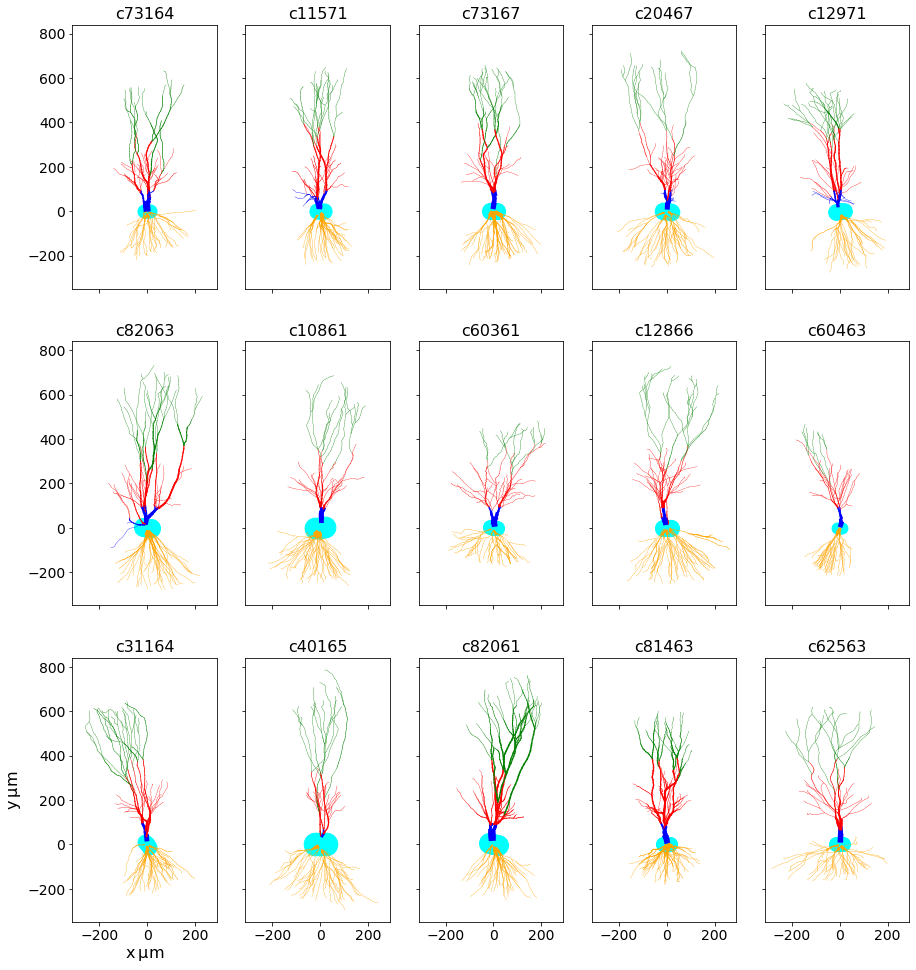

In [4]:
fig1,axs1 = plt.subplots(ncols=5,nrows=3,figsize=(15,16.5),sharex=True,sharey=True)
axs1_iter = iter(np.ravel(axs1))

for filename in glob.glob('./amaral_cells/*.hoc'):
    h.xopen(filename)
    h.xopen('./fig5_data/fixnseg.hoc')
    
    ax = next(axs1_iter)
    
    sl_dendrites = []
    sr_dendrites = []
    slm_dendrites = []
    
    for sec in h.allsec():

            if 'axon' not in sec.name():

                h.define_shape()
                x1,x2 = h.x3d(0),h.x3d(h.n3d()-1)
                y1,y2 = h.y3d(0),h.y3d(h.n3d()-1)

                theta = estimateNeuronOrientation()
                
                if filename[16:21] in handRotatedFile:
                    theta = [np.radians(angle) for fn,angle in zip(handRotatedFile,handRotations) if filename[16:21] in fn][0]


                x1,y1 = rotate2d(x1,y1,theta)
                x2,y2 = rotate2d(x2,y2,theta)
                w = sec.diam
                if sec in list(h.apical):
                        if abs(y1)<100 and abs(y2)<100:
                            color = 'blue'
                            sl_dendrites.append(sec)
                        elif abs(y1)<400 and abs(y2)<400:
                            color = 'red'
                            sr_dendrites.append(sec)
                        else:
                            color = 'green'
                            slm_dendrites.append(sec)

                for i in range(int(h.n3d()))[1:]:
                    x1,x2 = h.x3d(i-1),h.x3d(i)
                    y1,y2 = h.y3d(i-1),h.y3d(i)

                    x1,y1 = rotate2d(x1,y1,theta)
                    x2,y2 = rotate2d(x2,y2,theta)

                    w = h.diam3d(i)

                    if 'soma' in sec.name():
                        color = 'cyan'
                        ax.plot([x1,x2],[y1,y2],'.',ms=w,color=color)
                    else:
                        if sec in list(h.basal):
                            color = 'orange'
                            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=color,alpha=1.0)
                        elif sec in sl_dendrites:
                            color = 'blue'
                            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=color,alpha=1.0)
                        elif sec in sr_dendrites:
                            color='red'
                            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=color,alpha=1.0)
                        elif sec in slm_dendrites:
                            color = 'green'
                            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=color,alpha=1.0)
    ax.set_title(filename[15:21],fontsize=16)
    
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
axs1[2,0].set_xlabel('$\mathrm{x\:\mu m}$',fontsize=16)
axs1[2,0].set_ylabel('$\mathrm{y\:\mu m}$',fontsize=16)

In [5]:
for item in [fig1]:
    item.patch.set_visible(False)
    for ax in item.axes:
        ax.patch.set_visible(False)
        
# fig1.savefig('./amaral_cells/amaral_morphologies.svg')

In [5]:
import glob
n_compartments = []
for filename in glob.glob('./amaral_cells/*.hoc'):
    with open(filename+'_morph.csv','r') as myfile:
        morph_data = np.loadtxt(myfile,delimiter=',')
    n_compartments.append(len(morph_data))
print(min(n_compartments), max(n_compartments))

1213 2110


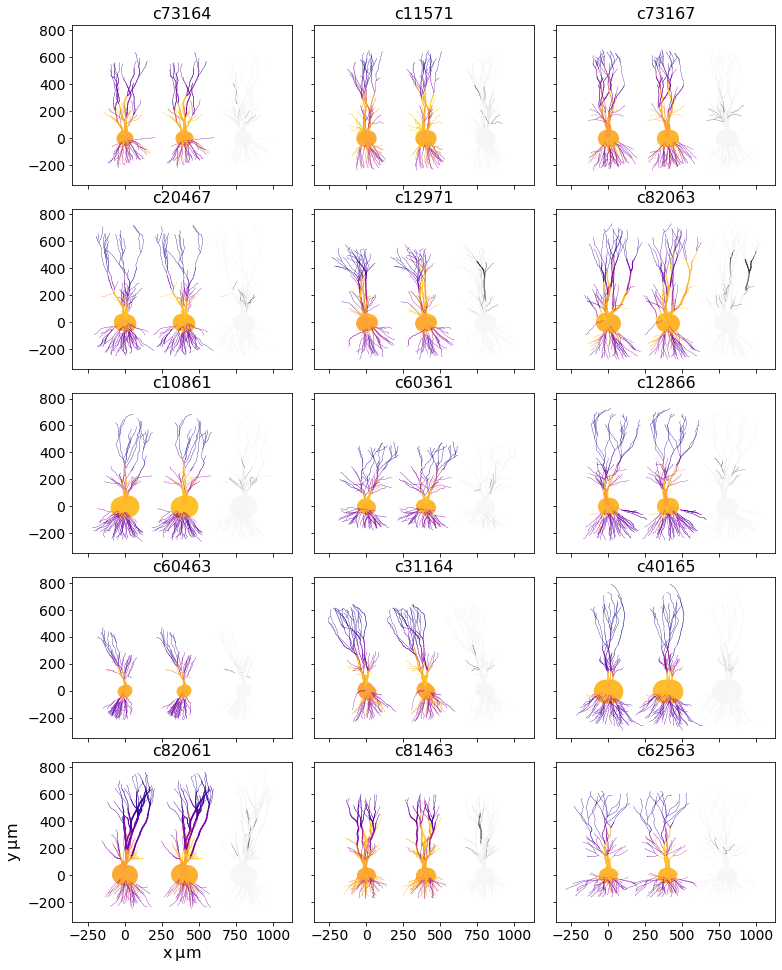

In [29]:
fig2,axs2 = plt.subplots(ncols=3,nrows=5,figsize=(12.6,16.5),sharex=True,sharey=True)
axs2_iter = iter(np.ravel(axs2))

cNorm1 = Normalize(vmin=0,vmax=110)
scalarMap1 = ScalarMappable(norm=cNorm1,cmap=plt.cm.plasma)

cNorm2 = Normalize(vmin=-5,vmax=80)
scalarMap2 = ScalarMappable(norm=cNorm2,cmap=plt.cm.Greys)

for filename in glob.glob('./amaral_cells/*.hoc'):
    
    ax = next(axs2_iter)
    
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_data = np.loadtxt(myfile,delimiter=',')
        
    for row in morph_data:
        cc,w,x1,y1,x2,y2,b0,bAP_ach,b2,bAP_pre,b4,b5,p0,pbAP_ach,p2,pbAP_pre,p4,p5,t0,tbAP_ach,t2,tbAP_pre,t4,t5  = row
        bAP_dif = bAP_ach - bAP_pre
        
        if cc == 0:
            ax.plot([x1,x2],[y1,y2],'.',ms=w,color=scalarMap1.to_rgba(bAP_pre))
            ax.plot([x1+400,x2+400],[y1,y2],'.',ms=w,color=scalarMap1.to_rgba(bAP_ach))
            ax.plot([x1+800,x2+800],[y1,y2],'.',ms=w,color=scalarMap2.to_rgba(bAP_dif))
            
        else:
            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=scalarMap1.to_rgba(bAP_pre))
            ax.plot([x1+400,x2+400],[y1,y2],'-',lw=w,color=scalarMap1.to_rgba(bAP_ach))
            ax.plot([x1+800,x2+800],[y1,y2],'-',lw=w,color=scalarMap2.to_rgba(bAP_dif))
            
    ax.set_title(filename[15:21],fontsize=16)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
axs2[4,0].set_xlabel('$\mathrm{x\:\mu m}$',fontsize=16)
axs2[4,0].set_ylabel('$\mathrm{y\:\mu m}$',fontsize=16)

fig2.subplots_adjust(wspace=0.1,hspace=0.15)

Text(0.5, 0, '$\\mathrm{\\Delta_{bAP} = bAP_{ACh} - bAP_{No\\:ACh}}$')

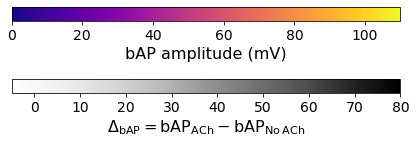

In [7]:
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(6,2))

ax1 = fig.add_axes([0.05,0.8,0.9,0.1])
ax2 = fig.add_axes([0.05,0.3,0.9,0.1])

cmap1 = plt.cm.plasma
cmap2 = plt.cm.Greys

ColorbarBase(ax1,cmap=cmap1,norm=cNorm1,orientation='horizontal')
ColorbarBase(ax2,cmap=cmap2,norm=cNorm2,orientation='horizontal')

plt.sca(ax1)
# fig.savefig('./amaral_cells/amaral_pbAPamp_gi.svg')
plt.xticks(fontsize=14)
plt.xlabel('bAP amplitude (mV)',fontsize=16)

plt.sca(ax2)
plt.xticks(fontsize=14)
plt.xlabel('$\mathrm{\Delta_{bAP} = bAP_{ACh} - bAP_{No\:ACh}}$',fontsize=16)

# fig.savefig('./amaral_cells/bAP_colorbars.svg')


In [30]:
for item in [fig2]:
    item.patch.set_visible(False)
    for ax in item.axes:
        ax.patch.set_visible(False)
        
fig2.savefig('./amaral_cells/amaral_bAP_morph_ach.svg', rasterized=True)
fig2.savefig('./amaral_cells/amaral_bAP_morph_ach_noraster.svg')

Text(0,0.5,'Probability')

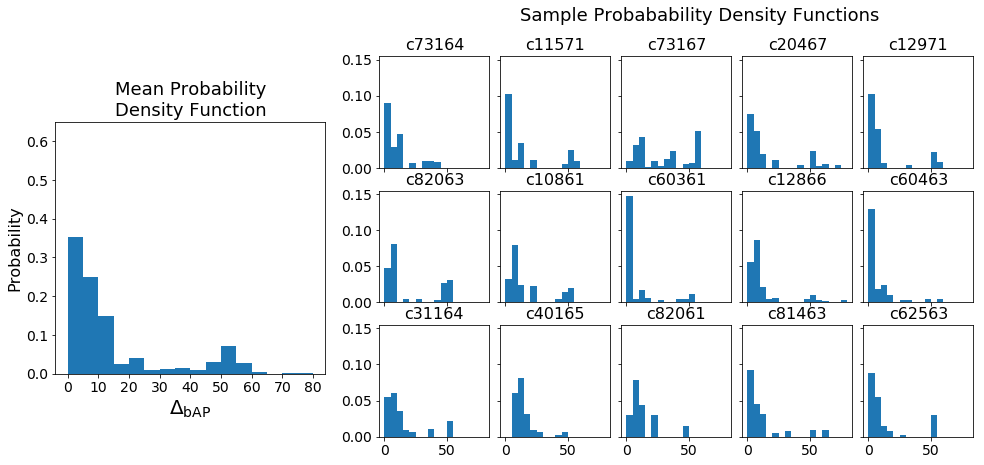

In [23]:
fig3,axs3 = plt.subplots(ncols=5,nrows=3,figsize=(15,7),sharex=True,sharey=True)
axs3_iter = iter(np.ravel(axs3))

hist_all = []

for filename in glob.glob('./amaral_cells/*.hoc'):
        
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_data = np.loadtxt(myfile,delimiter=',')
    
    ax = next(axs3_iter)
    sr_dif = [(row[7]-row[9]) for row in morph_data if (row[0]==3 and row[1]<=0.5)]
    ax.hist(sr_dif,bins=16,range=(0,80),density=True)
    
    ax.set_title(filename[15:21],fontsize=16)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    hist,edges = np.histogram(sr_dif,density=True,bins=16,range=(0,80))
    
    hist_all.append(hist)

fig3.subplots_adjust(left=0.35,wspace=0.1)
fig3.text(0.48,0.95,'Sample Probabability Density Functions',fontsize=18)

ax = fig3.add_axes([0.05,0.25,0.25,0.5])
width = np.diff(edges)[0]
ax.bar(edges[:-1],np.mean(hist_all,axis=0)*width,width=width,align='edge')
plt.sca(ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, 0.65])
plt.title('Mean Probability\nDensity Function',fontsize=18)
plt.xlabel('$\mathrm{\Delta_{bAP}}$',fontsize=20)
plt.ylabel('Probability',fontsize=16)

In [11]:
for item in [fig3]:
    item.patch.set_visible(False)
    for ax in item.axes:
        ax.patch.set_visible(False)
        
fig3.savefig('./amaral_cells/amaral_bAPdif_hist_ach.svg')

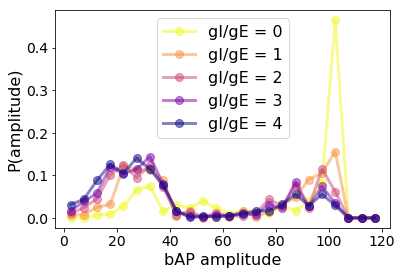

In [29]:
fig4 = plt.figure()

hist_av_all = []
sr_diams = []

for filename in glob.glob('./amaral_cells/*.hoc'):
    
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_data = np.loadtxt(myfile, delimiter=',')
        
    bAP = np.array([row[6:12] for row in morph_data if (row[0]==3 and row[1]<=0.6)]).T
    hist_av = []
    for bAPn in bAP:
        hist,edges = np.histogram(bAPn,bins=24,range=(0,120),density=True)
        hist_av.append(hist)
    hist_av_all.append(hist_av)
hist_av_all = np.array(hist_av_all)

hist_means = hist_av_all.mean(axis=0)
edge_means = np.mean([edges[1:],edges[:-1]],axis=0)
colors = plt.cm.plasma_r(np.linspace(0,1,5))

lines = []
width=np.diff(edges)[0]
for hm,c in zip(hist_means,colors):
    l = plt.plot(edge_means,hm*width,'-o',color=c,alpha=0.5,lw=3,ms=8)
    lines.append(l[0])
    
plt.legend(np.array(lines),['gI/gE = %d'%ii for ii in range(5)],loc='upper center',fontsize=16)
plt.xlabel('bAP amplitude',fontsize=16)
plt.ylabel('P(amplitude)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig4.savefig('./amaral_cells/amaral_pbAPamp_gi_ach.svg')

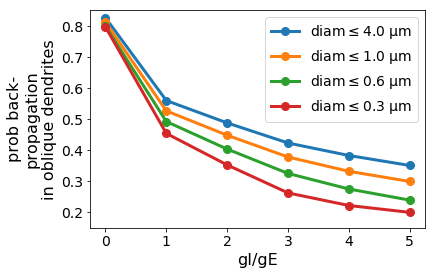

In [47]:
fig5 = plt.figure()

for thresh in [4.0,1.0,0.6,0.3]:
    hist_av_all = []
    for filename in glob.glob('./amaral_cells/*.hoc'):
    
        with open(filename+'_morph_ach.csv','r') as myfile:
            morph_data = np.loadtxt(myfile,delimiter=',')

        bAP = np.array([row[6:12] for row in morph_data if (row[0]==3 and row[1]<=thresh)]).T
        hist_av = []
        for bAPn in bAP:
            hist,edges = np.histogram(bAPn,bins=24,range=(0,120),density=True)
            hist_av.append(hist)
        hist_av_all.append(hist_av)
    mhist = np.array(hist_av_all).mean(axis=0)
    pbAP = mhist[:,8:].sum(axis=1)*5
    plt.plot(pbAP,'-o',lw=3,ms=8)
    
plt.xlabel('gI/gE',fontsize=16)
plt.ylabel('prob back-\npropagation\nin oblique dendrites',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.15, 0.85])

plt.legend(['diam$\leq$%.1f'%ii + ' $\mathrm{\mu}$m' for ii in [4.0,1.0,0.6,0.3]],fontsize=14,
          bbox_to_anchor=[1.0,1.0])

fig = plt.gcf()
# fig.savefig('./amaral_cells/amaral_pbAP_obl_gi_all_ach.svg')

In [51]:
mhist[:, 8:].sum(axis=1)*5

array([0.79636049, 0.45385202, 0.35228449, 0.26224491, 0.2217588 ,
       0.19969967])

In [15]:
filenames_ach = glob.glob('./amaral_cells/*_morph_ach.csv'); filenames_ach.sort()
filenames_nad = glob.glob('./amaral_cells/*_morph_nad.csv'); filenames_nad.sort()

pBAP_ctr = []
pBAP_ach = []
pBAP_nad = []

tBAP_ctr = []
tBAP_ach = []
tBAP_nad = []

for fna, fnn in zip(filenames_ach, filenames_nad):
    morph_data_ach = np.loadtxt(fna, delimiter=',')
    morph_data_nad = np.loadtxt(fnn, delimiter =',')
    
    seg_ach  = morph_data_ach[:, 0]
    diam_ach = morph_data_ach[:, 1]
    
    seg_nad  = morph_data_nad[:, 0]
    diam_nad = morph_data_nad[:, 1]
    
    pBAP_ctr.append(np.mean([p for p,s,d in zip(morph_data_ach[:, 15], seg_ach, diam_ach) if np.logical_and(s==3, d <=1.0)]))
    pBAP_ach.append(np.mean([p for p,s,d in zip(morph_data_ach[:, 13], seg_ach, diam_ach) if np.logical_and(s==3, d <=1.0)]))
    pBAP_nad.append(np.mean([p for p,s,d in zip(morph_data_nad[:, 15], seg_nad, diam_nad) if np.logical_and(s==3, d <=1.0)]))
    
    tBAP_ctr.append(np.nanmean([p for p,s,d in zip(morph_data_ach[:, 21], seg_ach, diam_ach) if np.logical_and(s==3, d <=1.0)]))
    tBAP_ach.append(np.nanmean([p for p,s,d in zip(morph_data_ach[:, 19], seg_ach, diam_ach) if np.logical_and(s==3, d <=1.0)]))
    tBAP_nad.append(np.nanmean([p for p,s,d in zip(morph_data_nad[:, 21], seg_nad, diam_nad) if np.logical_and(s==3, d <=1.0)]))
    

# pBAP_ctr, pBAP_ach, pBAP_nad = zip(*[(np.loadtxt(fna,delimiter=',')[:, 15], np.loadtxt(fna,delimiter=',')[:, 17], np.loadtxt(fnn,delimiter=',')[:, 15]) for fna, fnn in zip(filenames_ach, filenames_nad)])

Ctr = 0.356±0.054, ACh = 0.510±0.214, NAd = 0.470±0.209
Ctr vs ACh, p= 0.000, t(14)=-7.598
Ctr vs NAd, p= 0.000, t(14)=-7.097
ACh vs NAd, p= 0.007, t(14)=3.707


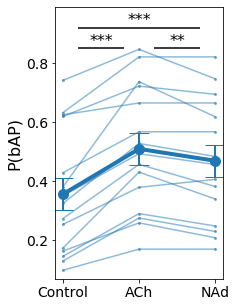

In [17]:
fig = plt.figure(figsize=(3,5))
P = np.vstack((pBAP_ctr, pBAP_ach, pBAP_nad))

stderr = P.std(axis=1, ddof=1)/np.sqrt(len(P.T))

plt.plot(P, '-o',color='C0', linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.errorbar(x=['Control', 'ACh', 'NAd'], y=P.mean(axis=1), yerr=stderr, capsize=10, fmt='-o', markersize=10, elinewidth=2, linewidth=4)
plt.ylabel('P(bAP)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

from scipy.stats import ttest_rel

stderr = P.std(axis=1, ddof=1)/np.sqrt(len(P.T))

print(r'Ctr = %.3f±%.3f, ACh = %.3f±%.3f, NAd = %.3f±%.3f'%(P.mean(axis=1)[0], P.std(axis=1, ddof=1)[0]/np.sqrt(len(P.T)), P.mean(axis=1)[1], P.std(axis=1, ddof=1)[1], P.mean(axis=1)[2], P.std(axis=1, ddof=1)[2]))

print('Ctr vs ACh, p= %.3f, t(%i)=%.3f'%(ttest_rel(pBAP_ctr, pBAP_ach).pvalue*3, len(P.T)-1, ttest_rel(pBAP_ctr, pBAP_ach).statistic))
print('Ctr vs NAd, p= %.3f, t(%i)=%.3f'%(ttest_rel(pBAP_ctr, pBAP_nad).pvalue*3, len(P.T)-1, ttest_rel(pBAP_ctr, pBAP_nad).statistic))
print('ACh vs NAd, p= %.3f, t(%i)=%.3f'%(ttest_rel(pBAP_ach, pBAP_nad).pvalue*3, len(P.T)-1, ttest_rel(pBAP_ach, pBAP_nad).statistic))

plt.hlines(y = 0.85, xmin=0.2, xmax=0.8)
plt.hlines(y = 0.85, xmin=1.2, xmax=1.8)
plt.hlines(y = 0.92, xmin=0.2, xmax=1.8)
plt.text(0.5, 0.86, '***', fontsize=16, color='k', horizontalalignment='center' )
plt.text(1.5, 0.86, '**',  fontsize=16, color='k', horizontalalignment='center' )
plt.text(1.0, 0.93, '***',  fontsize=16, color='k', horizontalalignment='center' )
plt.ylim(0.07, 0.99)

# plt.plot(np.zeros_like(pBAP_ctr), pBAP_ctr, 'o')
# plt.plot(np.ones_like(pBAP_ach), pBAP_ach, 'o')
# plt.plot(np.ones_like(pBAP_nad)+1, pBAP_nad, 'o')

fig.savefig('./amaral_cells/amaral_pbap_comparison.svg')

In [58]:
np.savetxt('pbAP.csv', P.T, header='Control,ACh,NAd', delimiter=',')

Ctr = 7.536±0.333, ACh = 6.471±0.253, NAd = 7.522±0.229
Ctr vs ACh, p= 0.000, t(14)=9.782
Ctr vs NAd, p= 2.622, t(14)=0.162
ACh vs NAd, p= 0.000, t(14)=-25.520


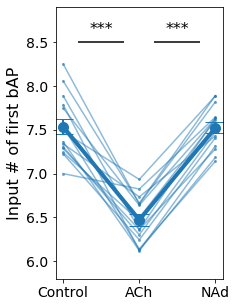

In [19]:
fig = plt.figure(figsize=(3,5))
T = np.vstack((tBAP_ctr, tBAP_ach, tBAP_nad))
stderr = T.std(axis=1, ddof=1)/np.sqrt(len(P.T))
plt.plot(T, '-o',color='C0', linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.errorbar(x=['Control', 'ACh', 'NAd'], y=T.mean(axis=1), yerr=stderr, capsize=10, fmt='-o', markersize=10, elinewidth=2, linewidth=4)
plt.ylabel('Input # of first bAP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

print(r'Ctr = %.3f±%.3f, ACh = %.3f±%.3f, NAd = %.3f±%.3f'%(T.mean(axis=1)[0], T.std(axis=1)[0], T.mean(axis=1)[1], T.std(axis=1)[1], T.mean(axis=1)[2], T.std(axis=1)[2]))

from scipy.stats import ttest_rel
print('Ctr vs ACh, p= %.3f, t(%i)=%.3f'%(ttest_rel(tBAP_ctr, tBAP_ach).pvalue*3, len(P.T)-1, ttest_rel(tBAP_ctr, tBAP_ach).statistic))
print('Ctr vs NAd, p= %.3f, t(%i)=%.3f'%(ttest_rel(tBAP_ctr, tBAP_nad).pvalue*3, len(P.T)-1, ttest_rel(tBAP_ctr, tBAP_nad).statistic))
print('ACh vs NAd, p= %.3f, t(%i)=%.3f'%(ttest_rel(tBAP_ach, tBAP_nad).pvalue*3, len(P.T)-1, ttest_rel(tBAP_ach, tBAP_nad).statistic))

plt.hlines(y = 8.5, xmin=0.2, xmax=0.8)
plt.hlines(y = 8.5, xmin=1.2, xmax=1.8)
plt.text(0.5, 8.6, '***', fontsize=16, color='k', horizontalalignment='center' )
plt.text(1.5, 8.6, '***', fontsize=16, color='k', horizontalalignment='center' )
plt.ylim(5.8,8.9)

fig.savefig('./amaral_cells/amaral_pbap_comparison_input.svg')

In [31]:
for filename in glob.glob('./amaral_cells/*.hoc'):
        
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_data = np.loadtxt(myfile,delimiter=',')
    
#     ax = next(axs3_iter)
    sr_dif = [(row[-5]-row[-3]) for row in morph_data if (row[0]==3 and row[1]<=0.5)]
    ax.hist(sr_dif,bins=16,range=(0,80),density=True)

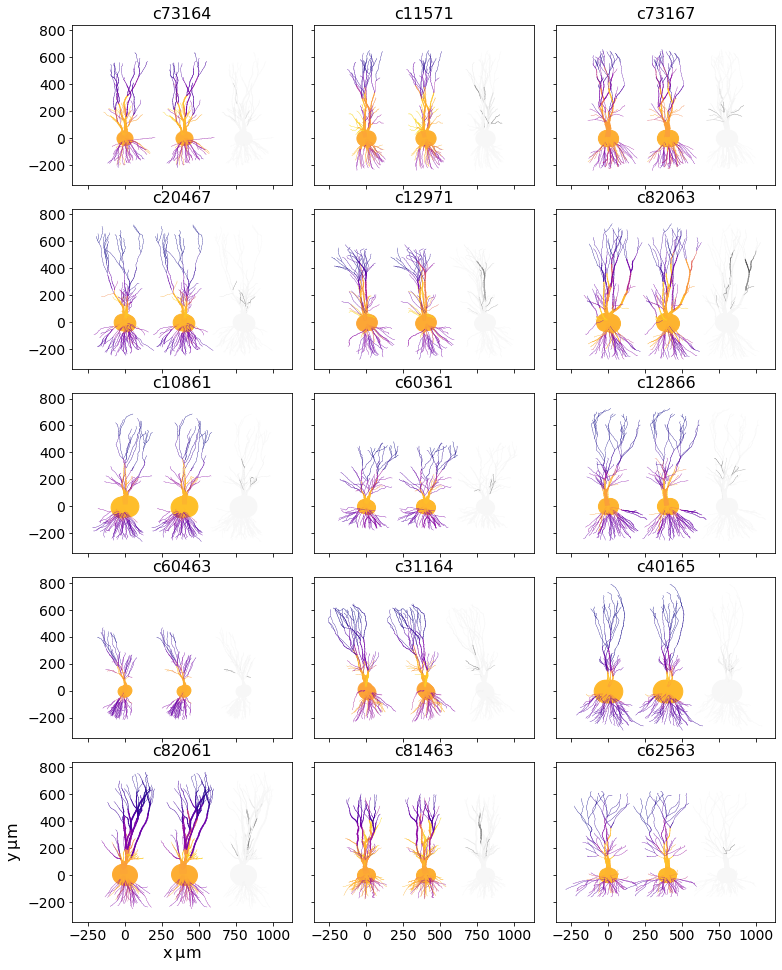

In [32]:
fig2,axs2 = plt.subplots(ncols=3,nrows=5,figsize=(12.6,16.5),sharex=True,sharey=True)
axs2_iter = iter(np.ravel(axs2))

cNorm1 = Normalize(vmin=0,vmax=110)
scalarMap1 = ScalarMappable(norm=cNorm1,cmap=plt.cm.plasma)

cNorm2 = Normalize(vmin=-5,vmax=80)
scalarMap2 = ScalarMappable(norm=cNorm2,cmap=plt.cm.Greys)

for filename in glob.glob('./amaral_cells/*.hoc'):
    
    ax = next(axs2_iter)
    
    with open(filename+'_morph_nad.csv','r') as myfile:
        morph_nad = np.loadtxt(myfile,delimiter=',')
        
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_ach = np.loadtxt(myfile,delimiter=',')
        
    for row_nad, row_ach in zip(morph_nad, morph_ach):
#         cc,w,x1,y1,x2,y2,b0,bAP_ach,b2,bAP_pre,b4,b5,p0,pbAP_ach,p2,pbAP_pre,p4,p5,t0,tbAP_ach,t2,tbAP_pre,t4,t5
        cc,w,x1,y1,x2,y2,b0,b1,b2,bAP_nad,b4,b5, p0, p1, p2, pbAP_nad, p4, p5, t0, t1, t2, tbAP_nad, t4, t5 = row_nad
        bAP_pre = row_ach[9]
        bAP_dif = bAP_nad - bAP_pre
        
        if cc == 0:
            ax.plot([x1,x2],[y1,y2],'.',ms=w,color=scalarMap1.to_rgba(bAP_pre))
            ax.plot([x1+400,x2+400],[y1,y2],'.',ms=w,color=scalarMap1.to_rgba(bAP_nad))
            ax.plot([x1+800,x2+800],[y1,y2],'.',ms=w,color=scalarMap2.to_rgba(bAP_dif))
            
        else:
            ax.plot([x1,x2],[y1,y2],'-',lw=w,color=scalarMap1.to_rgba(bAP_pre))
            ax.plot([x1+400,x2+400],[y1,y2],'-',lw=w,color=scalarMap1.to_rgba(bAP_nad))
            ax.plot([x1+800,x2+800],[y1,y2],'-',lw=w,color=scalarMap2.to_rgba(bAP_dif))
            
    ax.set_title(filename[15:21],fontsize=16)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
axs2[4,0].set_xlabel('$\mathrm{x\:\mu m}$',fontsize=16)
axs2[4,0].set_ylabel('$\mathrm{y\:\mu m}$',fontsize=16)

fig2.subplots_adjust(wspace=0.1,hspace=0.15)

Text(0.5, 0, '$\\mathrm{\\Delta_{bAP} = bAP_{NAd} - bAP_{No\\:NAd}}$')

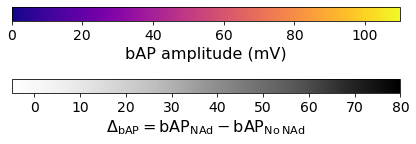

In [33]:
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(6,2))

ax1 = fig.add_axes([0.05,0.8,0.9,0.1])
ax2 = fig.add_axes([0.05,0.3,0.9,0.1])

cmap1 = plt.cm.plasma
cmap2 = plt.cm.Greys

ColorbarBase(ax1,cmap=cmap1,norm=cNorm1,orientation='horizontal')
ColorbarBase(ax2,cmap=cmap2,norm=cNorm2,orientation='horizontal')

plt.sca(ax1)
# fig.savefig('./amaral_cells/amaral_pbAPamp_gi.svg')
plt.xticks(fontsize=14)
plt.xlabel('bAP amplitude (mV)',fontsize=16)

plt.sca(ax2)
plt.xticks(fontsize=14)
plt.xlabel('$\mathrm{\Delta_{bAP} = bAP_{NAd} - bAP_{No\:NAd}}$',fontsize=16)

In [28]:
for item in [fig2]:
    item.patch.set_visible(False)
    for ax in item.axes:
        ax.patch.set_visible(False)
        
fig2.savefig('./amaral_cells/amaral_bAP_morph_nad.svg', rasterized=True)
fig2.savefig('./amaral_cells/amaral_bAP_morph_nad_noraster.svg')

In [ ]:
fig3,axs3 = plt.subplots(ncols=5,nrows=3,figsize=(15,7),sharex=True,sharey=True)
axs3_iter = iter(np.ravel(axs3))

hist_all = []

for filename in glob.glob('./amaral_cells/*.hoc'):
        
    with open(filename+'_morph_nad.csv','r') as myfile:
        morph_nad = np.loadtxt(myfile,delimiter=',')
        
    with open(filename+'_morph_ach.csv','r') as myfile:
        morph_ach = np.loadtxt(myfile,delimiter=',')
    
    ax = next(axs3_iter)
    sr_dif = [(row_nad[-3]-row_ach[-3]) for row_nad, row_ach in zip(morph_nad, morph_ach) if (row_nad[0]==3 and row_nad[1]<=0.5)]
    ax.hist(sr_dif,bins=16,range=(0,80),density=True)
    
    ax.set_title(filename[15:21],fontsize=16)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    hist,edges = np.histogram(sr_dif,density=True,bins=16,range=(0,80))
    
    hist_all.append(hist)

fig3.subplots_adjust(left=0.35,wspace=0.1)
fig3.text(0.48,0.95,'Sample Probabability Density Functions',fontsize=18)

ax = fig3.add_axes([0.05,0.25,0.25,0.5])
ax.bar(edges[:-1],np.mean(hist_all,axis=0),width=5,align='edge')
plt.sca(ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, 0.13])
plt.title('Mean Probability\nDensity Function',fontsize=18)
plt.xlabel('$\mathrm{\Delta_{bAP}}$',fontsize=20)
plt.ylabel('Probability',fontsize=16)

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ]),
 <a list of 7 Text yticklabel objects>)

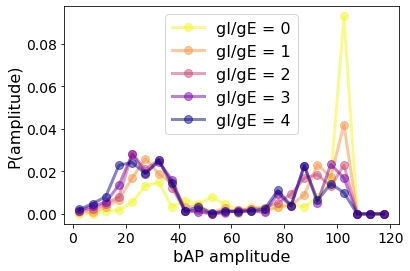

In [35]:
fig4 = plt.figure()

hist_av_all = []
sr_diams = []

for filename in glob.glob('./amaral_cells/*.hoc'):
    
    with open(filename+'_morph_nad.csv','r') as myfile:
        morph_data = np.loadtxt(myfile, delimiter=',')
        
    bAP = np.array([row[6:12] for row in morph_data if (row[0]==3 and row[1]<=0.6)]).T
    hist_av = []
    for bAPn in bAP:
        hist,edges = np.histogram(bAPn,bins=24,range=(0,120),density=True)
        hist_av.append(hist)
    hist_av_all.append(hist_av)
hist_av_all = np.array(hist_av_all)

hist_means = hist_av_all.mean(axis=0)
edge_means = np.mean([edges[1:],edges[:-1]],axis=0)
colors = plt.cm.plasma_r(np.linspace(0,1,5))

lines = []
for hm,c in zip(hist_means,colors):
    l = plt.plot(edge_means,hm,'-o',color=c,alpha=0.5,lw=3,ms=8)
    lines.append(l[0])
    
plt.legend(np.array(lines),['gI/gE = %d'%ii for ii in range(5)],loc='upper center',fontsize=16)
plt.xlabel('bAP amplitude',fontsize=16)
plt.ylabel('P(amplitude)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

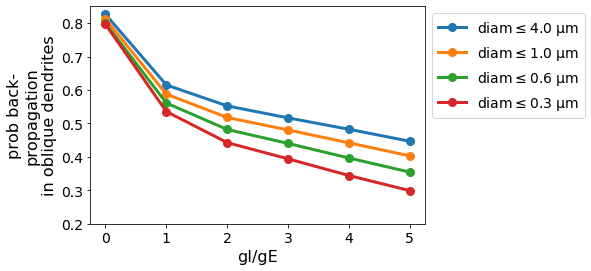

In [11]:
fig5 = plt.figure()

for thresh in [4.0,1.0,0.6,0.3]:
    hist_av_all = []
    for filename in glob.glob('./amaral_cells/*.hoc'):
    
        with open(filename+'_morph_nad.csv','r') as myfile:
            morph_data = np.loadtxt(myfile,delimiter=',')

        bAP = np.array([row[-6:] for row in morph_data if (row[0]==3 and row[1]<=thresh)]).T
        hist_av = []
        for bAPn in bAP:
            hist,edges = np.histogram(bAPn,bins=24,range=(0,120),density=True)
            hist_av.append(hist)
        hist_av_all.append(hist_av)
    mhist = np.array(hist_av_all).mean(axis=0)
    pbAP = mhist[:,8:].sum(axis=1)*5
    plt.plot(pbAP,'-o',lw=3,ms=8)
    
plt.xlabel('gI/gE',fontsize=16)
plt.ylabel('prob back-\npropagation\nin oblique dendrites',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.2, 0.85])

plt.legend(['diam$\leq$%.1f'%ii + ' $\mathrm{\mu}$m' for ii in [4.0,1.0,0.6,0.3]],fontsize=14,
          bbox_to_anchor=[1.0,1.0])

## Example Cells